# Assignment 3

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import csv
%matplotlib inline

In [4]:
# reading in index file

inventory = pd.read_csv("encyclopaediaBritannica-inventory.csv", header=None)
inventory.columns = ['file','volume']
print("\nNumber of text files: " + str(len(inventory)))


Number of text files: 195


## Selecting volumes for each edition

In [5]:
# ignore supplements & index volumes

first_ed = inventory[:3]
first_ed_reprint = inventory[3:7]
second_ed = inventory[6:16]
third_ed = inventory[16:34]
third_ed_reprint = inventory[34:52]
fourth_ed = inventory[56:96]
fifth_ed = inventory[96:116]
sixth_ed = inventory[116:136]
seventh_ed = inventory[152:172]
eighth_ed = inventory[173:194]

In [9]:
list(first_ed['volume']) # list() to print whole text

['Encyclopaedia Britannica; or, A dictionary of arts and sciences, compiled upon a new plan … - First edition, 1771, Volume 1, A-B - EB.1',
 'Encyclopaedia Britannica; or, A dictionary of arts and sciences, compiled upon a new plan … - First edition, 1771, Volume 2, C-L - EB.1',
 'Encyclopaedia Britannica; or, A dictionary of arts and sciences, compiled upon a new plan … - First edition, 1771, Volume 3, M-Z - EB.1']

In [5]:
# doesn't include reprints 
all_editions = [first_ed, second_ed, third_ed, fourth_ed, fifth_ed, sixth_ed, seventh_ed, eighth_ed]

In [6]:
# for testing
two_editions = [first_ed, second_ed]

## Basic statistics

In [10]:
# Reading in text files and generate volume, length (in words and characters) counts

def basic_data(editions):
    
    data = []
    
    for ed in editions: 
        length = 0
        words = 0
        volumes = 0

        for index, row in ed.iterrows():
            print("Reading: " + row['file'])

            f = open('text/' + row['file'], 'r', encoding="utf8")
            content = f.read()
            content = clean_up(content)
            length += len(content)
            volumes += 1

            words += len(content.split())

            f.close()
            
        data.append([volumes, length, words])
        data_df=pd.DataFrame(data,columns=['volumes', 'length_chars','length_words'])
    return data_df

In [231]:
basic_df = basic_data(all_editions)
basic_df

Reading: 144133901.txt
Reading: 144133902.txt
Reading: 144133903.txt
Reading: 144850370.txt
Reading: 144850373.txt
Reading: 144850374.txt
Reading: 144850375.txt
Reading: 144850376.txt
Reading: 144850377.txt
Reading: 144850378.txt
Reading: 144850379.txt
Reading: 190273289.txt
Reading: 190273290.txt
Reading: 190273291.txt
Reading: 149977338.txt
Reading: 149977873.txt
Reading: 149978642.txt
Reading: 149979156.txt
Reading: 149979622.txt
Reading: 149981189.txt
Reading: 149981670.txt
Reading: 149982181.txt
Reading: 149982692.txt
Reading: 149983206.txt
Reading: 190273372.txt
Reading: 191253798.txt
Reading: 192200061.txt
Reading: 191253799.txt
Reading: 191319917.txt
Reading: 191253800.txt
Reading: 191253817.txt
Reading: 191253818.txt
Reading: 191253819.txt
Reading: 192545783.txt
Reading: 192545784.txt
Reading: 191809865.txt
Reading: 191809866.txt
Reading: 191253825.txt
Reading: 191253826.txt
Reading: 191320556.txt
Reading: 191320557.txt
Reading: 192547776.txt
Reading: 192547777.txt
Reading: 19

,volumes,length_chars,length_words
0,3,14191040,2567260
1,10,56733498,10172846
2,18,96884019,17414509
3,40,103931985,18672098
4,20,103686840,18617826
5,20,103513075,18597305
6,20,119701529,21056156
7,21,131624089,22878318


In [234]:
# testing saving & loading from CSV

basic_df.to_csv('csv/basic_data.csv')
basic_reimport = pd.read_csv('csv/basic_data.csv')
print(basic_reimport) # edition 4 is actually 20 volumes because text files separate its volumes into part 1 & 2

   Unnamed: 0  volumes  length_chars  length_words
0           0        3      14191040       2567260
1           1       10      56733498      10172846
2           2       18      96884019      17414509
3           3       40     103931985      18672098
4           4       20     103686840      18617826
5           5       20     103513075      18597305
6           6       20     119701529      21056156
7           7       21     131624089      22878318


## Most referenced topics

**Note:** the terms entries/headers/words are used interchangeably, they all refer to the `ENTRY` part of an `ENTRY, definition`. References are links to other parts of the Encyclopaedia in a definition, of the form `See TOPIC`.

### Helper functions

#### For cleanup

In [57]:
def replace_by(s, a, b):
    """ perform a regex replacement, prints number of occurrences found and returns a string.
    s: string to make changes in
    a: string to remove 
    b: string to add
    returns: a string"""
    
    # print("Replacing \"" + a + "\" by \"" + b + "\", found " + str(len(re.findall(a, s))) + "...")
    return re.sub(a, b, s)

In [58]:
# Using regex cleanup ideas from: https://sites.temple.edu/tudsc/2014/08/12/text-scrubbing-hacks-cleaning-your-ocred-text/

def clean_up(s):
    """ Does a minimal cleanup of a string of text
    returns: a string
    """
    # print("Initial length: " + str(len(s)))
    s2 = replace_by(s, 'tbe', 'the')
    s3 = replace_by(s2, 'tiie', 'the')
    s4 = replace_by(s3, 'liis', 'his')
    s5 = replace_by(s4, 'bis', 'his')
    s6 = replace_by(s5, '■', '')
    s7 = replace_by(s6, 'ib','in') # was noticed by Ava in .txt files
    s8 = replace_by(s7, '¬','')
    s9 = replace_by(s8, '.(\.\.+)', '') # multiple periods; what about ellipsis though?
    # print("Clean up done!")
    return s9 # CAREFUL to always pass the right one to next, and return

In [59]:
# This uses the list of header/definition/refs dataframes for each edition, and performs a basic cleanup

def clean_up_definitions(editions):
    editions_cleaned = []
    for ed in editions:
        # realistically, a definition can't be shorter than 5 letters ("See x" is itself 5 characters long)
        ed = ed.loc[ed['def_length'] > 5]
        # remove headers with two letters as they are likely noise
        ed = ed.loc[ed['header_length'] > 2]
        # remove headers longer than 40 characters, as these are likely noise
        ed = ed.loc[ed['header_length'] < 40]
        
        # We might also want to drop header duplicates, as each entry should only be defined once
        # A good portion of these duplicates are probably noise (such as annotations in roman numerals)
        # We're not selecting the correct definition out of the duplicates here, just dropping them for the sake of simplicity
        ed.drop_duplicates(subset ="headers", keep = False, inplace = True)
        
        editions_cleaned.append(ed)
        
    return editions_cleaned

#### For extracting words and their definitions, and references ("See x")

In [60]:
# Uses RegEx to identify the definition of a word as being the content between the uppercase word and the next uppercase word

def find_definition(word, volume):
    start = re.search(word, volume).start()
    start_next = re.search(word, volume).end()
    
    second_word = re.search("[A-Z][A-Z]+", volume[start_next:])
    
    if second_word: # checking that second capitalised word exists (prevents NoneType exception)
        end = re.search("[A-Z][A-Z]+", volume[start_next:]).start()
        return volume[start_next+2:start_next+end] # +2 to ignore comma and space before a definition
    else:
        return ""

In [61]:
# Extracts entries (headers), their definitions, their respective lengths, and all references ("See x") from an edition

def extract_info(edition):
    
    headers = []
    definitions = []
    refs = [] # for counting up all instances of "See x" in volumes  
    
    for index, row in edition.iterrows():
        current_headers = []
        
        print("Reading: " + row['file'])
        f = open('text/' + row['file'], 'r', encoding="utf8")
        content = f.read()
        content = clean_up(content)
        
        # using https://stackoverflow.com/questions/9525993/get-consecutive-capitalized-words-using-regex
        # note: this ReGex is not entirely correct, as the first ReGex will select "MARTIAL" and "LAW" as separate entries
        # (while the second one will add a correct entry for "MARTIAL LAW")
        # "MARTIAL" will be cleaned out later due to having an empty definition, but "LAW" will not, leading to duplicates
        
        current_headers = re.findall('[A-Z][A-Z]+', content) # at least two uppercase letters following each other
        current_headers += re.findall('([A-Z][A-Z]+(?=\s[A-Z])(?:\s[A-Z][A-Z]+)+)', content) # two or more uppercase words
        refs += re.findall('See [^,\.]*', content) # matches "See x" until a comma or a period
        
        for word in current_headers:
            definitions.append(find_definition(word, content))
            
        headers = headers + current_headers
        
        f.close()

    data = pd.DataFrame(headers, columns =['headers'])
    data['definition'] = definitions
    data['header_length']  = data['headers'].str.len()
    data['def_length']  = data['definition'].str.len()
    return data, refs

In [62]:
# Generates a list of dataframes with words and their definitions for each edition

def words_and_definitions(editions):
    
    all_edition_data = []
    all_references = []
    
    for ed in editions:
        edition_data, references = extract_info(ed)
        all_edition_data.append(edition_data)
        all_references.append(references)
    return all_edition_data, all_references

### Generating headers, definitions and references for all editions and saving to CSV

In [14]:
# function takes in a list of editions and extracts the relevant data
# here, we processed two editions at a time to perform the processing in chunks (it takes around a minute for each txt file)
seventh_eighth_data, seventh_eighth_refs = words_and_definitions([seventh_ed, eighth_ed])

Reading: 192984259.txt
Reading: 193057500.txt
Reading: 193108322.txt
Reading: 193696083.txt
Reading: 193322690.txt
Reading: 193819043.txt
Reading: 193322688.txt
Reading: 193696084.txt
Reading: 193469090.txt
Reading: 193638940.txt
Reading: 192693199.txt
Reading: 193108323.txt
Reading: 193322689.txt
Reading: 193819044.txt
Reading: 194474782.txt
Reading: 193469091.txt
Reading: 193469092.txt
Reading: 193057501.txt
Reading: 193913444.txt
Reading: 193819045.txt
Reading: 192984260.txt
Reading: 193322698.txt
Reading: 193696085.txt
Reading: 193696086.txt
Reading: 193108324.txt
Reading: 193109113.txt
Reading: 193109114.txt
Reading: 193108325.txt
Reading: 193322700.txt
Reading: 193109115.txt
Reading: 193469392.txt
Reading: 193696087.txt
Reading: 193916150.txt
Reading: 193696088.txt
Reading: 193592632.txt
Reading: 193322699.txt
Reading: 193819046.txt
Reading: 193108326.txt
Reading: 193322701.txt
Reading: 193469393.txt
Reading: 193819047.txt


In [15]:
seventh_eighth_cleaned = clean_up_definitions(seventh_eighth_data)
seventh_eighth_cleaned[0]

,headers,definition,header_length,def_length
55,AAHUS,"a little town of Germany, in the circle of\nWe...",5,210
56,AALBORG,one of the four sees (stiffs) into which\nthe ...,7,2275
58,AALEN,"a bailiwick in the circle of Jaxt, in the king...",5,773
59,AALSMEER,"a town in the arrondissement of Am\nsterdam, i...",8,205
60,AALTEN,"a town in the arrondissement of Zutphen,\nand ...",6,119
...,...,...,...,...
123231,PLATE CCCCXCV,Fin. 17.\n,13,9
123232,PLATE CCCCXCVH,4\nn „ - .\nI .\nh\n———\n©,14,21
123233,OTMISIEM IPAIM\nJPJLATE,cccxcix.\nSf Bloomsbrn^\n,22,23
123234,ZOOPHYTES\nPLATE,)11.\nAsatrLs hunbricoicUis.\nTetjurhynckus Un...,15,216


In [16]:
# save the two dataframes to CSV

seventh_eighth_cleaned[0].to_csv('csv/seventh_ed_data.csv')
seventh_eighth_cleaned[1].to_csv('csv/eighth_ed_data.csv')

In [63]:
# Generates a cleaned dataframe with counts of references, from the list of all references picked up in each edition

def generate_ref_counts(refs):
    
    all_ref_counts = []
    
    for ref in refs:
        # Converting unique counts to a DataFrame for easy visualisation
        ref_df = pd.DataFrame(ref)
        ref_counts = ref_df[0].value_counts()
        ref_counts = pd.DataFrame(ref_counts)
        ref_counts['references'] = ref_counts.index
        ref_counts.columns = ['count', 'references']
#         ref_counts = ref_counts.reset_index(True)

        # cleaning ref counts (removing non-topics such as "See the next article")
        ref_counts = ref_counts.loc[ref_counts['references'] != "See the next article"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See there"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See thefe articles"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See these articles"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See Vol"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See p"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See fig"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See that article"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See the preceding article"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See Supplement"]
        ref_counts = ref_counts.loc[ref_counts['references'] != "See SUPPLEMENT"]
        ref_counts = ref_counts.loc[~ref_counts['references'].str.contains("Plate")]
        ref_counts = ref_counts.loc[~ref_counts['references'].str.contains("plate")]
        ref_counts = ref_counts.loc[~ref_counts['references'].str.contains("Index")]
        ref_counts = ref_counts.loc[~ref_counts['references'].str.contains("In\ndex")]
        ref_counts = ref_counts.loc[~ref_counts['references'].str.contains("index")]
        
        # Change formatting to not have "See" in topic name
        ref_counts['references'] = ref_counts['references'].str.replace(r'See ', '')
        
        all_ref_counts.append(ref_counts)
    
        
    
    return all_ref_counts

In [24]:
seventh_eighth_refs_counts = generate_ref_counts(seventh_eighth_refs)
seventh_eighth_refs_counts[0]

,count,references
See Ornithology,43,Ornithology
See Mammalia,35,Mammalia
See Music,31,Music
See Metaphysics,27,Metaphysics
See Anatomy,26,Anatomy
...,...,...
See Chemist^\nZINZENDORF,1,Chemist^\nZINZENDORF
See the article Arabia,1,the article Arabia
See Hales’\nChronology,1,Hales’\nChronology
See the I ransia\ntion of Bayle’s Dictionary,1,the I ransia\ntion of Bayle’s Dictionary


In [25]:
seventh_eighth_refs_counts[0].to_csv('csv/seventh_ed_refs.csv')
seventh_eighth_refs_counts[1].to_csv('csv/eighth_ed_refs.csv')

#### Example of manual cleaning

In [ ]:
# seventh edition had "the article Optics" references in addition to Optics
# this code checks the counts, manually updates the ones for Optics, and removes "the article Optics" entry

In [55]:
# check counts
# seventh_eighth_refs_counts[0].loc[seventh_eighth_refs_counts[0].references == "the article Optics"]
seventh_eighth_refs_counts[0].loc[seventh_eighth_refs_counts[0].references == "Optics"]

,Unnamed: 0,count,references
17,See Optics,23,Optics


In [54]:
# add counts
seventh_eighth_refs_counts[0].loc[seventh_eighth_refs_counts[0].references == "Optics", "count"] = 11 + 12

In [56]:
# remove "the article Optics" entry
seventh_eighth_refs_counts[0] = seventh_eighth_refs_counts[0].loc[seventh_eighth_refs_counts[0].references != "the article Optics"]

In [62]:
# re-sort the dataframe, as updated entry might be at a different position in popularity
seventh_eighth_refs_counts[0] = seventh_eighth_refs_counts[0].sort_values(by=['count'], ascending=False)

In [58]:
# save to CSV
seventh_eighth_refs_counts[0].to_csv('csv/seventh_ed_refs_fixed.csv')

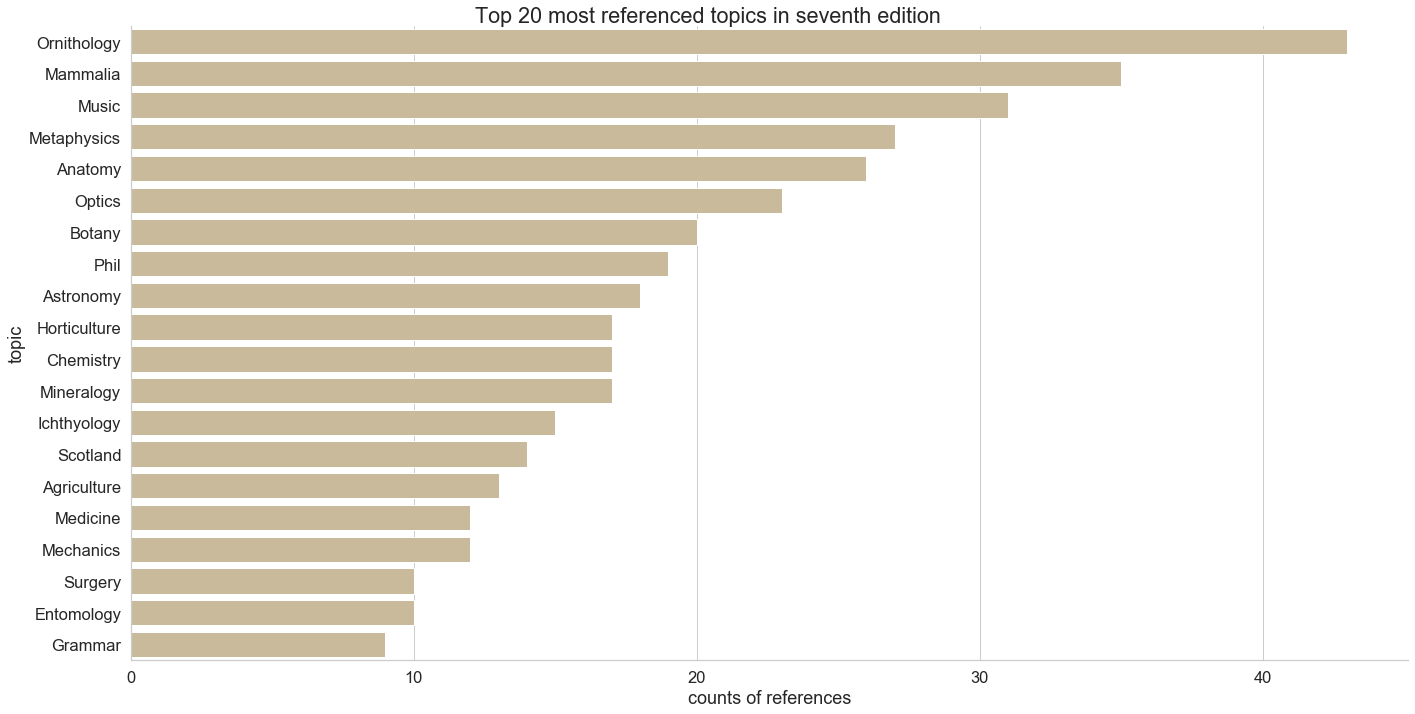

In [32]:
# visualise top 20

sns.set(font_scale=1.5)
sns.set_style("whitegrid")
ax = sns.catplot(x='count', y='references', data=seventh_eighth_refs_counts[0].head(20), kind='bar', height=10, aspect=2, color="#cfbd93")
ax.fig.suptitle("Top 20 most referenced topics in seventh edition", y=1)
ax.set_axis_labels('counts of references', 'topic')

### Overall number of references in each edition

In [28]:
# load in references from CSV

references = []
references.append(pd.read_csv('csv/first_ed_refs.csv'))
references.append(pd.read_csv('csv/second_ed_refs.csv'))
references.append(pd.read_csv('csv/third_ed_refs.csv'))
references.append(pd.read_csv('csv/fourth_ed_refs.csv'))
references.append(pd.read_csv('csv/fifth_ed_refs.csv'))
references.append(pd.read_csv('csv/sixth_ed_refs.csv'))
references.append(pd.read_csv('csv/seventh_ed_refs_fixed_2.csv'))
references.append(pd.read_csv('csv/eighth_ed_refs.csv'))
len(references)

8

In [29]:
# calculate sum of references for each edition

sum_refs = []
for refs in references:
    sum_refs.append(refs['count'].sum())
sum_refs

[4909, 7020, 9363, 8811, 8687, 8895, 3489, 6032]

Text(0, 0.5, 'counts of references')

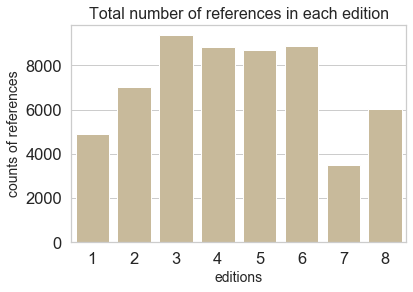

In [30]:
# visualise sums

# dip might be due to a change in format?
# more longform articles, with content within, rather than entries with references to main topic?

ed_count = list(range(1, 9))
sns.set_style("whitegrid")
ax = sns.barplot(x= ed_count, y=sum_refs, color="#cfbd93")
ax.set_title('Total number of references in each edition', fontsize=16)
ax.set_xlabel('editions', fontsize=14)
ax.set_ylabel('counts of references', fontsize=14)

### One of the longest words in each edition

In [33]:
# load in headers for each edition

headers = []
headers.append(pd.read_csv('csv/first_ed_data.csv'))
headers.append(pd.read_csv('csv/second_ed_data.csv'))
headers.append(pd.read_csv('csv/third_ed_data.csv'))
headers.append(pd.read_csv('csv/fourth_ed_data.csv'))
headers.append(pd.read_csv('csv/fifth_ed_data.csv'))
headers.append(pd.read_csv('csv/sixth_ed_data.csv'))
headers.append(pd.read_csv('csv/seventh_ed_data.csv'))
headers.append(pd.read_csv('csv/eighth_ed_data.csv'))
len(headers)

8

In [41]:
# this is mostly manual inspection, as the longest headers are often errors
# selected not necessarily the longest valid word, but one of the longest ones that has a more readable/identifiable description

In [84]:
headers[0].loc[headers[0]['header_length'] > 30]

,Unnamed: 0,headers,definition,header_length,def_length
4419,7779,EXTENSOR MINIMI DIGITI PROPRIUS,This is a kind of collateral or auxiliary mufc...,31,383
4483,7861,THE PARTS OF GENERATION IN\nMALES,The fpermatic arteries go out moft commonly fr...,32,4066
15803,29601,ENCYCLOPAEDIA BRITANNICA\nVOLUME,"he T H I R D,\nEncyclopaedia Britannica;\nO R,...",31,47


In [85]:
re.sub("\n", " ", headers[0].iloc[4419].definition) # remove \n for simpler formatting

'This is a kind of collateral or auxiliary mufcle of the extenfor communis, of which it appears almoit al ways to be more or lefs a portion. It is fixed along the fuperior external half of the ul na, from whence its long fmall tendon runs down in company with the fourth tendon of the extenfor commu nis, all the way to the little finger, where it joins it, and is infer ted with it. '

### Words that reference a specific topic

In [13]:
# again, requires manual inspection of what definitions are not just references to the main article
# as well as having concise and fairly clean, interesting defs

In [21]:
headers[0].loc[(headers[0]['definition'].str.contains("See Chemistry")) & (headers[0]['def_length'] > 35)].iloc[50:100]

,Unnamed: 0,headers,definition,header_length,def_length
10870,20411,TALS,"in natural biftory, are defined to be foffile\...",4,180
10967,20831,MINIUM,"or red-lead. See Chemistry, p. 84.\nand 136.\n",6,44
10998,20871,MIXTURE,"a compound, or affemblage of feveral dif\nfere...",7,88
11149,21172,MUFFLE,"in Chemittry. See Chemistry, p. 109.\n",6,37
11462,22446,NOCTILUCA,"a fpecies of phofphorus, fo called be-\ncaufe ...",9,170
12501,24221,PLUMBUM,"lead See Chemistry, p. 84.\nPlume, in botany S...",7,68
12657,24520,PRECIPITANT,"in chemiftry, is applied to any liquor,\nwhich...",11,364
12895,24816,PYROTECHNY,"the art of fire, or afcience which teaches\nth...",10,121
12928,24862,QUARTATION,a method of purifying gold by melting\nthree p...,10,149
12944,24881,QUINQUATRIA,"in Roman antiquity, feftivals celebra-\nyoung ...",11,249


In [27]:
re.sub("\n", " ", headers[0].iloc[10998].definition)

'a compound, or affemblage of feveral dif ferent bodies in the fame mafs. See Chemistry. '

### Words with most references to other topics

In [31]:
headers_with_refs = headers.copy()

In [32]:
# find all references of the form of "See x" in each definition

for ed in range(0, len(headers_with_refs)):
    refs_in_desc = []
    for index, row in headers_with_refs[ed].iterrows():   
        refs_in_desc.append(len(re.findall('See [^,\.]*', row['definition']))) # matches "See x" until a comma or a period
    headers_with_refs[ed] = headers_with_refs[ed].assign(refs_in_desc=refs_in_desc)

In [40]:
headers_with_refs[3].describe()

,Unnamed: 0,header_length,def_length,refs_in_desc
count,26070.000000,26070.000000,26070.000000,26070.000000
mean,55320.488953,7.520483,725.914423,0.242079
std,36662.148468,3.147801,1557.828398,0.486152
min,5.000000,3.000000,6.000000,0.000000
25%,21171.500000,5.000000,96.250000,0.000000
50%,54119.500000,7.000000,246.000000,0.000000
75%,87723.750000,9.000000,698.000000,0.000000
max,122922.000000,39.000000,33766.000000,7.000000


In [238]:
# Again, the checking is manual, as some of the headers/definitions are noise that is picked up 
# (eg. a "CCCCLXXXVIL"-type header)

In [44]:
# prints out the words with most references in a specific edition, with a count of those words and the number of refs 
# if there are several, word parameter can be used to print specific ones
# adjuster is for easily looking at words with less references, if most referenced words are noise 

def most_refs_word(ed, word, adjuster):
    most_refs = np.max(headers_with_refs[ed]['refs_in_desc']) - adjuster 
    longest = headers_with_refs[ed].loc[headers_with_refs[ed]['refs_in_desc'] == (most_refs)]
    print("Number of words with most refs: " + str(len(longest)) + ", with number of refs: "\
          + str(most_refs) + "\n")
    print(list(longest.headers)[word])
    print(re.sub("\n", " ", list(longest.definition)[word]))

In [45]:
most_refs_word(3, 1, 0)

Number of words with most refs: 2, with number of refs: 7

MOULD
or Mold, in the mechanic arts, &c. a cavity artificially cut, with a defign to give its form or impreflion to fome fofter matter applied therein. Moulds are implements of great ufe in fculpture, foundery, &c. The workmen employed in melting the mineral or metallic ore dug out of mines, have their feveral moulds to receive the melted metal as it comes out of the fur nace ; but thefe are different according to the diverfity of metals and works. In gold mines, they have moulds for ingots ; in filver mines, for bars; in copper and lead mines, for pigs or falmons; in tin mines, for pigs and ingots; and in iron mines, for fows, chimney backs, anvils, caldrons, pots, and other large utenfils and mer- chandifes of iron ; which are here caft, as it were, at firft hand. Moulds of founders of large works, as ftatues, bells, guns, and other brazen works, are of wax, fupported within-fide by what we call a core, and covered with- out-

In [131]:
# print out words with specific number of references

list(headers_with_refs[0].loc[headers_with_refs[0]['refs_in_desc'] == 6].headers)

['AXIS', 'CALCULUS']

### Proportional topic popularity changes

In [13]:
# calculate proportional popularity of topics (count of references to topic, adjusted to total number of references in that ed)
# and visualise the popularity across editions

def change_in_topic_vis(topic, editions_ref_counts):
    
    counts = []
    sum_refs = []
    
    for i in range(0, len(editions_ref_counts)):
        try: 
            counts.append(int(editions_ref_counts[i].loc[editions_ref_counts[i].references == topic]['count']) / editions_ref_counts[i]['count'].sum())
        except: # handle case where a topic was never referenced in early editions
            counts.append(0) 
    # proportional popularity, by dividing count by total number of references in an edition
    ed_count = list(range(1, 9))
    sns.set_style("whitegrid")
    ax = sns.barplot(x= ed_count, y=counts, color="#cfbd93")
    ax.set_title('Popularity of ' + topic + ' across editions', fontsize=16)
    ax.set_xlabel('editions', fontsize=14)
    ax.set_ylabel('proportion of references', fontsize=14)

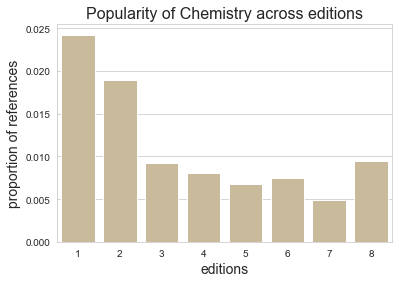

In [15]:
change_in_topic_vis("Chemistry", references)
# a decrease in popularity could mean entries were added to the long-form article,
# so doesn't necessarily mean topic itself became less popular;
# all that we can state from this is that proportion of entries referencing that topic decreased

### Total number of references for top 20 topics for all editions

In [10]:
# goes through each dataframe and checks whether that reference exists in total_refs already
# if it does, skips it (it was already calculated)
# if does not yet, goes through all further editions and sums the references to that topic

total_refs = pd.DataFrame(columns=['ref', 'count'])

for i in range(0, len(references)):
    for index, row in references[i].iterrows():
        #only process a word in an edition if it was not processed by a previous edition
        if (row.references not in total_refs.values):          
            count = 0
            for ed in references[i:]:
                try: 
                    count += int(ed.loc[ed.references == row.references]['count'])
                except: # handle case where there's not a reference to a topic in an edition
                    pass
            total_refs = total_refs.append({'ref': row.references, 'count': count}, ignore_index=True)
            
print(total_refs)

                                    ref count
0                               Anatomy  1235
1                                   Law   497
2                              Medicine   429
3                             Chemistry   608
4                             Astronomy   397
...                                 ...   ...
22761       Hamilton’s edition\nof Reid     1
22762                            Quilon     1
22763  the\n(Euvres Completes de Volney     1
22764       the historical\npart of art     1
22765                            Police     1

[22766 rows x 2 columns]


In [14]:
# sort by most referenced

total_refs = total_refs.sort_values(by=['count'], ascending=False)

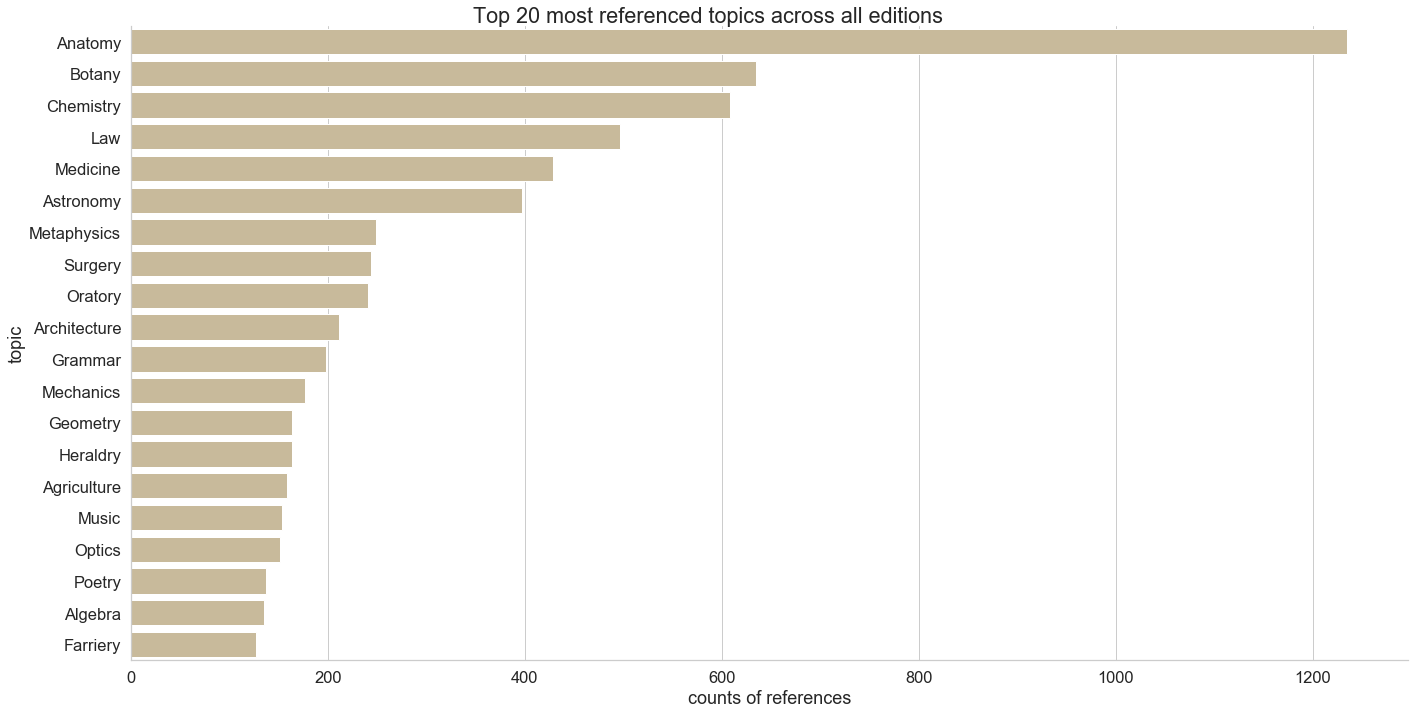

In [18]:
# visualise top 20 most referenced topics across all editions

sns.set(font_scale=1.5)
sns.set_style("whitegrid")
ax = sns.catplot(x='count', y='ref', data=total_refs.head(20), kind='bar', height=10, aspect=2, color="#cfbd93")
ax.fig.suptitle("Top 20 most referenced topics across all editions", y=1)
ax.set_axis_labels('counts of references', 'topic')

### Unused code

In [37]:
# find definition of a specific word in a specific edition

list(headers[5].loc[headers[5]['headers'].str.contains("ENTABLATURE")].definition)

['or Entablement, in Archi\ntecture, is that part of an order of a column which is\nover the capital, and comprehends the architrave, frize,\nand corniche. See Architecture, chap. i.\n']

In [38]:
# show definition of a specific word across all editions

for i in range(0, len(headers)):
    print(list(headers[i].loc[headers[i]['headers'].str.match("MIXTURE")].definition))

['a compound, or affemblage of feveral dif\nferent bodies in the fame mafs. See Chemistry.\n']
['a compound, or affemblage of feveral\ndifferent bodies in the fame mafs. Simple mixture,\nconfifts only in the Ample appofition of parts of diffe\nrent bodies to each other. Thus, when powders of\ndifferent kinds are rubbed together, the mixture is on\nly Ample, and each of the powders retains its particu\nlar charafters. In like manner, when oil and water\nare mixed together, though the parts of both are con\nfounded, fo that the liquor may appear to be homoge\nneous, we cannot fay that there is any more than a\nAmple appofition of the parts, as the oil and water may\nvery eafily be again feparated from each other. But\nthe cafe is very different when bodies chemically\nmixed ; for then one or both bodies affume new pro\nperties, and can by no means be difeovered in their\nproper form without a particular chemical procefs ad\napted to this purpofe. Hence chemical mixture is\nattended with 